In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter
import _pickle as cPickle

from tqdm import tqdm # to measure progress of for loops

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_74400/796912209.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [2]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

# Problem 1. Random Forest

## Long term performance with Random Forest Classifier, optimal hyper-parameters, and optimal features

In [6]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [7]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [8]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [9]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [10]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [11]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [12]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])

### Open and read the shap features over the holding period 2003 - 2018

In [13]:
with open(r'Random Forest Parameters/shap_features.pkl','rb') as f:
    shap_rf = cPickle.load(f)
with open(r'Random Forest Parameters/optimal_hyperparameters.pkl','rb') as f:
    opt_hyper_params_rf = cPickle.load(f)

In [14]:
# Convert shap_rf to a list of features
shap_rf_list = []
for feats in shap_rf:
    shap_rf_list.extend(list(feats))

# Find the 10 most common features
c = Counter(shap_rf_list)
c.most_common(10)

[('fcf_yield', 42),
 ('cf_yield', 41),
 ('oancfy', 41),
 ('oancfy_q', 39),
 ('fcf_csfhdq', 37),
 ('lt_ppentq', 37),
 ('evmq', 36),
 ('dprq', 36),
 ('oepsxy', 35),
 ('dvpspq', 35)]

In [15]:
# Choose 10 most common shap features to be the optimal features
opt_rf_feats = [val[0] for val in c.most_common(10)]

In [17]:
# Initialize the list of classifiers with the optimal hyperparameters
rf_classifiers = []

for hyp_par in opt_hyper_params_rf:
    rf_clf = RandomForestClassifier(**hyp_par)
    rf_classifiers.append(rf_clf)

In [18]:
# for i in tqdm(range(len(start_dates)-1)):
#     rf_classifiers[i].fit(training_data[i],training_labels[i])

In [19]:
# new_training_data = []
# new_valid_data = []
# new_test_data = []

In [20]:
# for i in range(len(start_dates)-1): 
#     new_training_data.append(training_data[i][opt_rf_feats])
#     new_valid_data.append(valid_data[i][opt_rf_feats])
#     new_test_data.append(test_data[i][opt_rf_feats])

In [21]:
# new_valid_data[1].columns

In [22]:
# for i in range(len(start_dates)-1):
#     float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

#     scaler = StandardScaler()
#     new_training_data[i] = new_training_data[i].copy()
#     new_valid_data[i] = new_valid_data[i].copy()
#     new_test_data[i] = new_test_data[i].copy()
#     new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
#     new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
#     new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [23]:
# for i in tqdm(range(len(start_dates)-1)):
#     rf_classifiers[i].fit(new_training_data[i],training_labels[i])

In [24]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [25]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [26]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [27]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][opt_rf_feats].values),columns=opt_rf_feats) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][opt_rf_feats].values),columns=opt_rf_feats) for i in range(len(start_dates)-1)]

In [28]:
opt_test_data[1]

,fcf_yield,cf_yield,oancfy,oancfy_q,fcf_csfhdq,lt_ppentq,evmq,dprq,oepsxy,dvpspq
0,-0.206398,-0.645950,-0.171431,-0.142220,-0.222443,-0.138036,0.080339,-0.042204,-0.093053,-0.595682
1,-0.420684,2.792597,0.852188,0.210787,-0.359797,-0.137840,-1.060025,-0.112661,-0.578317,-0.408904
2,-0.020692,-0.102749,-0.051488,-0.110094,-0.118421,-0.143237,0.013442,-0.006715,0.215752,-0.198778
3,0.049269,-0.199209,-0.200669,-0.110826,0.041014,-0.126797,0.011170,-0.030968,0.107470,-0.595682
4,0.006049,-0.332625,1.494588,1.340345,0.089421,-0.136787,0.018215,0.007137,0.307992,0.478292
...,...,...,...,...,...,...,...,...,...,...
1131,-0.062845,-0.275955,-0.011859,0.030989,-0.150327,-0.125497,-0.007114,0.091678,-0.133157,0.618376
1132,-0.036429,-0.386222,-0.195607,-0.156680,0.068950,-0.122519,0.014597,-0.023044,0.099449,-0.408904
1133,-0.242139,0.414694,-0.090863,0.021878,-0.311895,-0.146362,0.002207,-0.042204,-0.297586,-0.595682
1134,-0.032373,-0.453909,-0.213380,-0.163768,0.006329,-0.099544,0.015523,-0.042204,0.051323,-0.595682


In [29]:
x_rf = [1]
ret_rf = []

for i in tqdm(range(len(start_dates)-1)):
        rf_classifiers[i].fit(opt_training_data[i],training_labels[i])
        preds = rf_classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_rf.append(profit_i)
        num_names = len(opt_test_data[i])
        x_rf.append(x_rf[i] + (x_rf[i]/num_names)*profit_i)

100%|███████████████████████████████████████████| 56/56 [00:16<00:00,  3.39it/s]


In [30]:
opt_training_data[0]

,fcf_yield,cf_yield,oancfy,oancfy_q,fcf_csfhdq,lt_ppentq,evmq,dprq,oepsxy,dvpspq
0,-0.364674,-0.373115,-0.254676,-0.210633,-0.387421,-0.149403,0.011737,0.000913,-0.303291,-0.342313
1,0.197588,0.141487,-0.241345,-0.190014,0.179362,-0.156643,-0.005808,-0.042189,0.137554,-0.100479
2,-0.245033,-0.713570,-0.241345,-0.190014,-0.310581,-0.156643,-0.005808,-0.042189,0.029276,-0.608331
3,-0.029521,-0.416773,0.786906,12.731855,0.653886,-0.156643,-0.005808,-0.042189,3.157725,-0.608331
4,0.106482,0.132656,0.093656,0.134457,0.183774,-0.144333,0.007720,-0.042189,-0.001660,-0.608331
...,...,...,...,...,...,...,...,...,...,...
11948,-0.015125,-0.391696,0.012074,-0.013080,0.000351,-0.141993,0.021511,-0.042189,0.110484,-0.608331
11949,0.062716,-0.143016,0.387533,0.543976,0.230902,-0.137175,0.010447,-0.014956,0.547462,1.326343
11950,0.117617,1.706237,2.376090,3.858418,0.178434,-0.156643,-0.005808,-0.042189,1.127520,-0.608331
11951,0.527356,0.401059,-0.141076,-0.507338,0.532646,-0.156643,-0.005808,-0.042189,-0.102204,0.020438


In [32]:
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['random forest strategy'] = x_rf

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_74400/828307751.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)


### Plot the P/L curves and compute the Sharpe Ratio

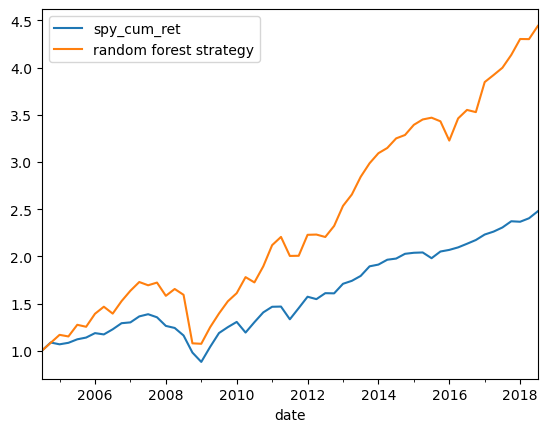

In [33]:
SPY.plot();

In [34]:
strategy_mean_ret = (SPY['random forest strategy'] - 1).diff().mean()
strategy_std = (SPY['random forest strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.47419724271363933


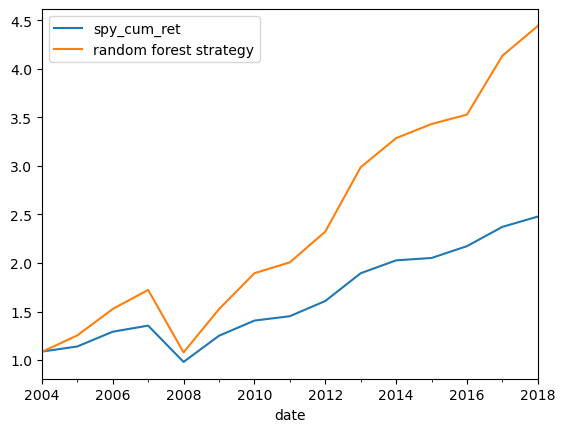

In [35]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [36]:
strategy_mean_ret = (SPY['random forest strategy'] - 1).diff().mean()
strategy_std = (SPY['random forest strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7825792987665202
